In [1]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import pandas as pd

import numpy as np
from sklearn.preprocessing import (
    RobustScaler,
    OneHotEncoder,
)
from sklearn.metrics import (
    mean_squared_error,
)

from sklearn.feature_selection import SelectKBest, VarianceThreshold, f_regression
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

import shap

from common import (
    apply_onehot_encoder,
    apply_custom_encoder,
    compare_pipelines,
    grid_search,
    get_linear_regression_scores,
    build_pipeline,
    plot_predictions,
    split,
)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
pd.set_option("display.max_colwidth", None)

In [3]:
data = pd.read_csv("clean_data.csv")
data.drop(columns="Unnamed: 0", inplace=True)
data

,PrimaryPropertyType,Latitude,Longitude,NumberofBuildings,PropertyGFATotal,LargestPropertyUseType,SecondLargestPropertyUseType,ThirdLargestPropertyUseType,ENERGYSTARScore,SiteEnergyUse(kBtu),...,ElectricityUse(Percentage),SteamUse(Percentage),NaturalGasUse(Percentage),LargestUseTypeGFA(Percentage),SecondLargestUseTypeGFA(Percentage),ThirdLargestUseTypeGFA(Percentage),ParkingGFA(Percentage),NumberOfYearsENERGYSTARCertified,BuildingAge,NumberOfPropertyUses
0,Leisure,47.61220,-122.33799,0.30103,4.946624,Leisure,None,None,60.0,6.858920,...,54.61,27.73,17.66,100.00,0.00,0.00,0.00,0.0,89,1
1,Leisure,47.61317,-122.33393,0.30103,5.015221,Leisure,ServiceFacility,Leisure,61.0,6.923655,...,38.66,0.00,61.34,80.99,14.55,4.46,14.55,0.0,20,3
2,Leisure,47.61393,-122.33810,0.30103,5.980508,Leisure,None,None,43.0,7.860859,...,68.23,29.71,2.06,79.12,0.00,0.00,20.57,0.0,47,1
3,Leisure,47.61412,-122.33664,0.30103,4.787609,Leisure,None,None,56.0,6.832163,...,40.75,32.59,26.66,100.00,0.00,0.00,0.00,0.0,90,1
4,Leisure,47.61375,-122.34047,0.30103,5.244478,Leisure,ServiceFacility,Leisure,75.0,7.151450,...,37.88,0.00,62.12,70.31,38.73,0.00,35.31,0.0,36,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1531,ServiceFacility,47.54067,-122.37441,0.30103,4.261548,Leisure,None,None,NaN,5.969455,...,67.84,0.00,32.16,100.00,0.00,0.00,0.00,0.0,34,1
1532,ServiceFacility,47.59625,-122.32283,0.30103,4.204147,Leisure,None,None,NaN,5.977850,...,41.73,0.00,58.27,100.00,0.00,0.00,0.00,0.0,12,1
1533,ServiceFacility,47.63644,-122.35784,0.30103,4.119190,Leisure,ServiceFacility,Leisure,NaN,6.760867,...,31.08,0.00,68.92,57.63,42.37,0.00,0.00,0.0,42,3
1534,ServiceFacility,47.52832,-122.32431,0.30103,4.149281,Leisure,ServiceFacility,School,NaN,5.857014,...,48.49,0.00,51.51,46.81,46.10,3.43,0.00,0.0,27,5


We will set aside a data set that contains energy star score information

In [4]:
energy_data = data.copy()
energy_data = energy_data.loc[~energy_data["ENERGYSTARScore"].isna()]

# Separation of training and test data

In [5]:
y_emissions = data["TotalGHGEmissions"]
X = data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

In [6]:
(X_train, X_test, y_train, y_test) = split(X, y_emissions)

# Baselines

### Naive model

In [7]:
mean_prediction = np.mean(y_train)
rmse_mean = np.sqrt(mean_squared_error(y_train, [mean_prediction] * len(y_train)))
print("Mean Prediction:", mean_prediction)
print("RMSE (Mean Model):", rmse_mean)

Mean Prediction: 1.747429278972513
RMSE (Mean Model): 0.6139707599972686


### Linear Regression with OneHotEncoder

In [8]:
X_train_one_hot, X_test_one_hot = apply_onehot_encoder(X_train, X_test, data)

get_linear_regression_scores(X_train_one_hot, y_train, X_test_one_hot, y_test)

Train R2 score:  0.7441692894975488
Train RMSE score:  0.3094310092072903
Test R2 score:  0.6727799160634558
Test RMSE score:  0.3453128974982727


# Preprocessing

Defining the different possible preprocessing operations

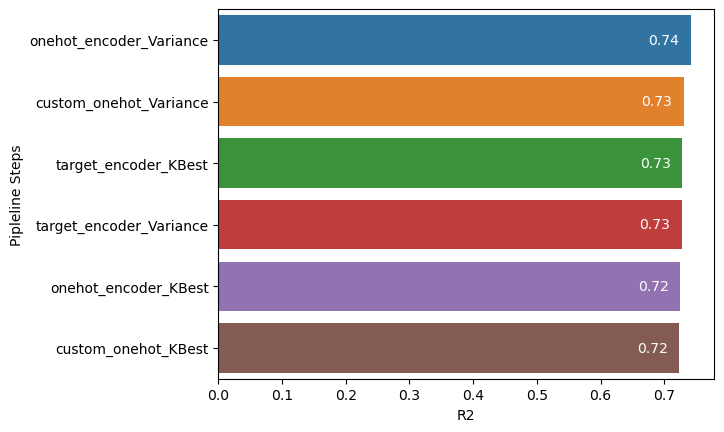

In [9]:
compare_pipelines(X_train, y_train, LinearRegression())

The pipeline that uses OneHotEncoder with the Variance feature selection yields the best R2 score on a LinearRegression model. However, the feature selection algorithms could yield better results with different hyperparameters. We will therefore use GridSearchCV to help selecting the best values

# GridSearchCV

In [10]:
model_comparison = pd.DataFrame()

In [11]:
kbest_params = {
    "selectkbest__k": [8, 15, "all"],
    "selectkbest__score_func": [f_regression],
}

variance_params = {"variancethreshold__threshold": [0.1, 0.5, 0.75, 0.9]}

### Linear Regression

In [12]:
def linear_regression_grid_search(additional_params=None, selector=None):
    param_grid = {}
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_emissions,
        LinearRegression(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = linear_regression_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21


In [13]:
model_comparison = linear_regression_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36


In [14]:
model_comparison = linear_regression_grid_search(variance_params, VarianceThreshold())

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21


### SVR

#### Without selector

In [15]:
def svr_grid_search(additional_params=None, selector=None):
    param_grid = {
        "svr__C": [1e-2, 0.5, 1],
        "svr__epsilon": [1e-2, 0.5, 1],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(X, y_emissions, SVR(), param_grid, model_comparison, selector)


model_comparison = svr_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
3,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23


#### With SelectKBest Selector

In [16]:
model_comparison = svr_grid_search(kbest_params, SelectKBest())

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
3,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23
4,SVR(),SelectKBest(),355.9806,0.6000,0.06,0.38,0.6869,0.3715,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>, 'svr__C': 0.01, 'svr__epsilon': 1}",0.03,6.53


#### With Variance Threshold Selector

In [17]:
model_comparison = svr_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
3,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23
4,SVR(),SelectKBest(),355.9806,0.6000,0.06,0.38,0.6869,0.3715,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>, 'svr__C': 0.01, 'svr__epsilon': 1}",0.03,6.53
5,SVR(),VarianceThreshold(),356.1334,0.6021,0.05,0.17,0.7443,0.4402,"{'svr__C': 0.01, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.9}",0.02,4.05


### ElasticNet

#### Without selector

In [18]:
def elastic_grid_search(additional_params=None, selector=None):
    param_grid = {
        "elasticnet__alpha": [1e-2, 1e-1, 0.3],
        "elasticnet__l1_ratio": [1e-2, 1e-1, 1],
        "elasticnet__random_state": [42],
    }
    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X, y_emissions, ElasticNet(), param_grid, model_comparison, selector
    )


model_comparison = elastic_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
6,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
3,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23
4,SVR(),SelectKBest(),355.9806,0.6000,0.06,0.38,0.6869,0.3715,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>, 'svr__C': 0.01, 'svr__epsilon': 1}",0.03,6.53
5,SVR(),VarianceThreshold(),356.1334,0.6021,0.05,0.17,0.7443,0.4402,"{'svr__C': 0.01, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.9}",0.02,4.05


#### With SelectKBest selector

In [19]:
model_comparison = elastic_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
3,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
7,ElasticNet(),SelectKBest(),345.1130,0.5860,0.10,0.60,0.6159,0.2952,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.01,2.49
4,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23
5,SVR(),SelectKBest(),355.9806,0.6000,0.06,0.38,0.6869,0.3715,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>, 'svr__C': 0.01, 'svr__epsilon': 1}",0.03,6.53
6,SVR(),VarianceThreshold(),356.1334,0.6021,0.05,0.17,0.7443,0.4402,"{'svr__C': 0.01, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.9}",0.02,4.05


#### With VarianceThreshold selector

In [20]:
model_comparison = elastic_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
3,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
8,ElasticNet(),VarianceThreshold(),344.8837,0.5819,0.11,0.28,0.7140,0.4050,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,2.46
4,ElasticNet(),SelectKBest(),345.1130,0.5860,0.10,0.60,0.6159,0.2952,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.01,2.49
5,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23
6,SVR(),SelectKBest(),355.9806,0.6000,0.06,0.38,0.6869,0.3715,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>, 'svr__C': 0.01, 'svr__epsilon': 1}",0.03,6.53
7,SVR(),VarianceThreshold(),356.1334,0.6021,0.05,0.17,0.7443,0.4402,"{'svr__C': 0.01, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.9}",0.02,4.05


### RandomForest

#### Without selector

In [21]:
def random_forest_grid_search(additional_params=None, selector=None):
    param_grid = {
        "randomforestregressor__n_estimators": [50, 70, 90],
        "randomforestregressor__min_samples_split": [5, 6, 7],
        "randomforestregressor__criterion": [
            "squared_error",
            "friedman_mse",
            "poisson",
        ],
        "randomforestregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_emissions,
        RandomForestRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = random_forest_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
9,RandomForestRegressor(),None,196.7363,0.3185,0.73,0.74,0.5590,0.2412,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.40,55.11
2,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
3,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
4,ElasticNet(),VarianceThreshold(),344.8837,0.5819,0.11,0.28,0.7140,0.4050,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,2.46
5,ElasticNet(),SelectKBest(),345.1130,0.5860,0.10,0.60,0.6159,0.2952,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.01,2.49
6,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23
7,SVR(),SelectKBest(),355.9806,0.6000,0.06,0.38,0.6869,0.3715,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>, 'svr__C': 0.01, 'svr__epsilon': 1}",0.03,6.53
8,SVR(),VarianceThreshold(),356.1334,0.6021,0.05,0.17,0.7443,0.4402,"{'svr__C': 0.01, 'svr__epsilon': 1, 'variancethreshold__threshold': 0.9}",0.02,4.05


#### With SelectKBest selector

In [22]:
model_comparison = random_forest_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
10,RandomForestRegressor(),SelectKBest(),179.9053,0.3251,0.72,0.72,0.5665,0.2489,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.39,161.81
2,RandomForestRegressor(),None,196.7363,0.3185,0.73,0.74,0.5590,0.2412,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.40,55.11
3,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
4,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
5,ElasticNet(),VarianceThreshold(),344.8837,0.5819,0.11,0.28,0.7140,0.4050,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,2.46
6,ElasticNet(),SelectKBest(),345.1130,0.5860,0.10,0.60,0.6159,0.2952,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.01,2.49
7,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23
8,SVR(),SelectKBest(),355.9806,0.6000,0.06,0.38,0.6869,0.3715,"{'selectkbest__k': 'all', 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>, 'svr__C': 0.01, 'svr__epsilon': 1}",0.03,6.53


#### With VarianceThreshold selector

In [23]:
model_comparison = random_forest_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,RandomForestRegressor(),SelectKBest(),179.9053,0.3251,0.72,0.72,0.5665,0.2489,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.39,161.81
3,RandomForestRegressor(),None,196.7363,0.3185,0.73,0.74,0.5590,0.2412,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.40,55.11
4,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
11,RandomForestRegressor(),VarianceThreshold(),341.9893,0.6169,0.00,0.26,0.7152,0.4044,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.75}",0.25,136.90
5,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
6,ElasticNet(),VarianceThreshold(),344.8837,0.5819,0.11,0.28,0.7140,0.4050,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,2.46
7,ElasticNet(),SelectKBest(),345.1130,0.5860,0.10,0.60,0.6159,0.2952,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.01,2.49
8,SVR(),None,355.9806,0.6000,0.06,0.33,0.7023,0.3895,"{'svr__C': 0.01, 'svr__epsilon': 1}",0.02,1.23


### Gradient Boosting

#### Without Selector

In [24]:
def gradient_boosting_grid_search(additional_params=None, selector=None):
    param_grid = {
        "gradientboostingregressor__n_estimators": [75, 80, 81],
        "gradientboostingregressor__loss": [
            "squared_error",
            "absolute_error",
            "huber",
        ],
        "gradientboostingregressor__min_samples_split": [4, 5, 6],
        "gradientboostingregressor__random_state": [42],
    }

    if additional_params:
        param_grid.update(additional_params)

    return grid_search(
        X,
        y_emissions,
        GradientBoostingRegressor(),
        param_grid,
        model_comparison,
        selector,
    )


model_comparison = gradient_boosting_grid_search()

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,RandomForestRegressor(),SelectKBest(),179.9053,0.3251,0.72,0.72,0.5665,0.2489,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.39,161.81
3,RandomForestRegressor(),None,196.7363,0.3185,0.73,0.74,0.5590,0.2412,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.40,55.11
12,GradientBoostingRegressor(),None,223.0902,0.3044,0.76,0.75,0.5517,0.2358,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 75, 'gradientboostingregressor__random_state': 42}",0.19,26.83
4,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
5,RandomForestRegressor(),VarianceThreshold(),341.9893,0.6169,0.00,0.26,0.7152,0.4044,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.75}",0.25,136.90
6,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
7,ElasticNet(),VarianceThreshold(),344.8837,0.5819,0.11,0.28,0.7140,0.4050,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,2.46
8,ElasticNet(),SelectKBest(),345.1130,0.5860,0.10,0.60,0.6159,0.2952,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.01,2.49


#### With SelectKBest Selector


In [25]:
model_comparison = gradient_boosting_grid_search(
    kbest_params,
    SelectKBest(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,RandomForestRegressor(),SelectKBest(),179.9053,0.3251,0.72,0.72,0.5665,0.2489,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.39,161.81
3,RandomForestRegressor(),None,196.7363,0.3185,0.73,0.74,0.5590,0.2412,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.40,55.11
13,GradientBoostingRegressor(),SelectKBest(),198.6806,0.3112,0.75,0.74,0.5546,0.2377,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 75, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.25,101.46
4,GradientBoostingRegressor(),None,223.0902,0.3044,0.76,0.75,0.5517,0.2358,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 75, 'gradientboostingregressor__random_state': 42}",0.19,26.83
5,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
6,RandomForestRegressor(),VarianceThreshold(),341.9893,0.6169,0.00,0.26,0.7152,0.4044,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.75}",0.25,136.90
7,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81
8,ElasticNet(),VarianceThreshold(),344.8837,0.5819,0.11,0.28,0.7140,0.4050,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42, 'variancethreshold__threshold': 0.1}",0.01,2.46


#### With VarianceThreshold selector

In [26]:
model_comparison = gradient_boosting_grid_search(
    variance_params,
    VarianceThreshold(),
)

,Model,Selector,Test RMSE,Test RMSE (Log),Test R2,Train Mean R2,Train Mean RMSE,Train Mean MAE,Best params,Mean Fit Time,Runtime
0,LinearRegression(),None,158.9387,0.3009,0.76,0.74,0.5553,0.2364,{},0.04,0.21
1,LinearRegression(),SelectKBest(),168.1382,0.3162,0.74,0.74,0.5598,0.2407,"{'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.02,0.36
2,RandomForestRegressor(),SelectKBest(),179.9053,0.3251,0.72,0.72,0.5665,0.2489,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.39,161.81
3,RandomForestRegressor(),None,196.7363,0.3185,0.73,0.74,0.5590,0.2412,"{'randomforestregressor__criterion': 'poisson', 'randomforestregressor__min_samples_split': 7, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42}",0.40,55.11
4,GradientBoostingRegressor(),SelectKBest(),198.6806,0.3112,0.75,0.74,0.5546,0.2377,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__n_estimators': 75, 'gradientboostingregressor__random_state': 42, 'selectkbest__k': 8, 'selectkbest__score_func': <function f_regression at 0x1623fd3f0>}",0.25,101.46
5,GradientBoostingRegressor(),None,223.0902,0.3044,0.76,0.75,0.5517,0.2358,"{'gradientboostingregressor__loss': 'absolute_error', 'gradientboostingregressor__min_samples_split': 4, 'gradientboostingregressor__n_estimators': 75, 'gradientboostingregressor__random_state': 42}",0.19,26.83
6,LinearRegression(),VarianceThreshold(),332.2626,0.5607,0.18,0.33,0.6983,0.3871,{'variancethreshold__threshold': 0.9},0.01,0.21
14,GradientBoostingRegressor(),VarianceThreshold(),336.7522,0.5785,0.12,0.34,0.6963,0.3829,"{'gradientboostingregressor__loss': 'squared_error', 'gradientboostingregressor__min_samples_split': 5, 'gradientboostingregressor__n_estimators': 81, 'gradientboostingregressor__random_state': 42, 'variancethreshold__threshold': 0.75}",0.19,106.20
7,RandomForestRegressor(),VarianceThreshold(),341.9893,0.6169,0.00,0.26,0.7152,0.4044,"{'randomforestregressor__criterion': 'friedman_mse', 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__n_estimators': 50, 'randomforestregressor__random_state': 42, 'variancethreshold__threshold': 0.75}",0.25,136.90
8,ElasticNet(),None,344.8837,0.5819,0.11,0.60,0.6137,0.2932,"{'elasticnet__alpha': 0.3, 'elasticnet__l1_ratio': 1, 'elasticnet__random_state': 42}",0.01,0.81


The LinearRegression model provides the best results as it has the lowest RMSE score, meaning this model makes fewer large errors than other models. The Random Forest combined with the SelectKBest selector yields good results as well. A little more feature engineering could yield even better results.

---

# Feature Importance

In [27]:
pipeline = make_pipeline(
    make_column_transformer(
        (
            OneHotEncoder(handle_unknown="ignore", sparse_output=False),
            make_column_selector(dtype_include=object),
        ),
        remainder="passthrough",
    ),
    RobustScaler(),
)

In [28]:
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.fit_transform(X_test)

In [29]:
model = LinearRegression()
model.fit(X_train_transformed, y_train)
model.score(X_test_transformed, y_test)

0.7618642712541621

Permutation explainer: 309it [00:15,  8.11it/s]                         


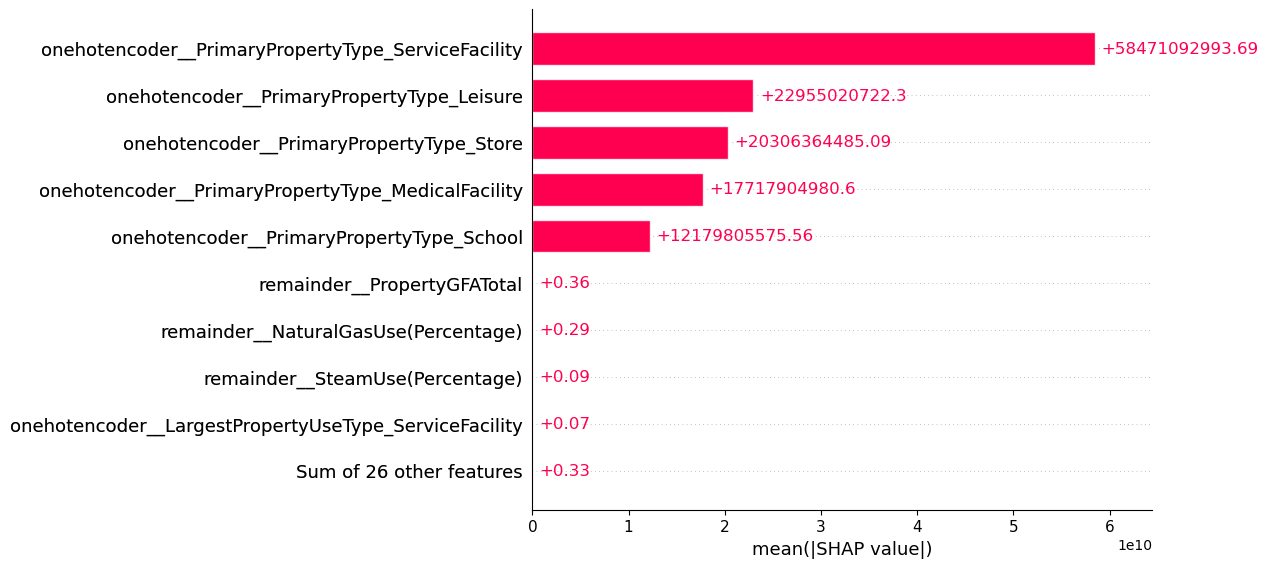

In [30]:
explainer = shap.Explainer(model.predict, X_test_transformed)
shap_values = explainer(
    pd.DataFrame(X_test_transformed,
                 columns=pipeline[:-1].get_feature_names_out())
)

shap.plots.bar(shap_values)

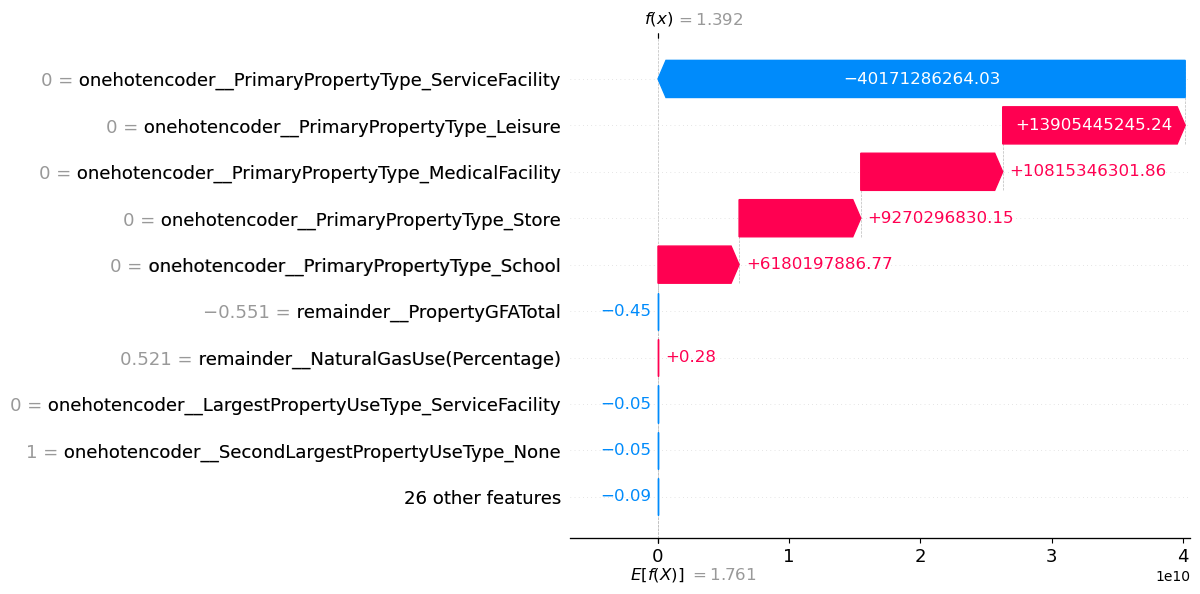

In [31]:
shap.plots.waterfall(shap_values[154])

In [32]:
model = RandomForestRegressor(
    criterion="poisson",
    min_samples_split=5,
    n_estimators=50,
    random_state=42,
)
model.fit(X_train_transformed, y_train)
model.score(X_test_transformed, y_test)

0.7280205295944425

Permutation explainer: 309it [00:27,  6.87it/s]                         


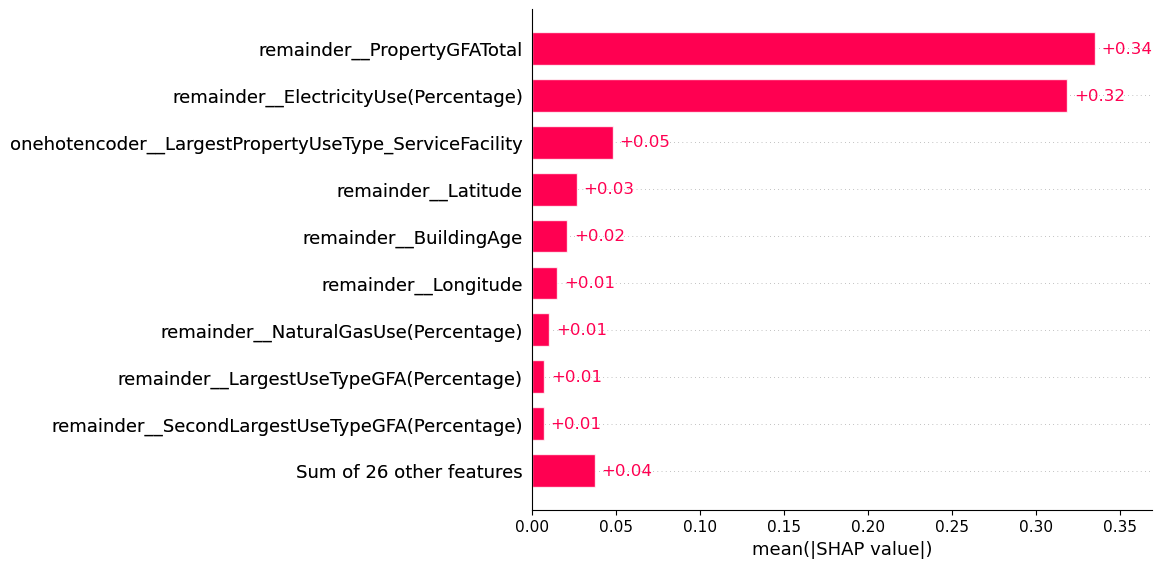

In [33]:
explainer = shap.Explainer(model.predict, X_test_transformed)
shap_values = explainer(
    pd.DataFrame(X_test_transformed,
                 columns=pipeline[:-1].get_feature_names_out())
)

shap.plots.bar(shap_values)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


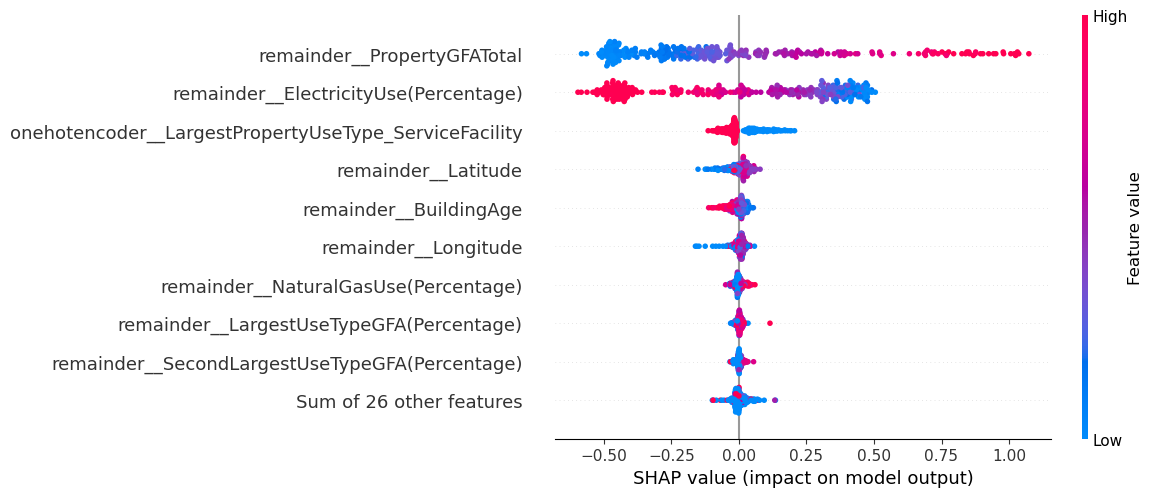

In [34]:
shap.plots.beeswarm(shap_values)

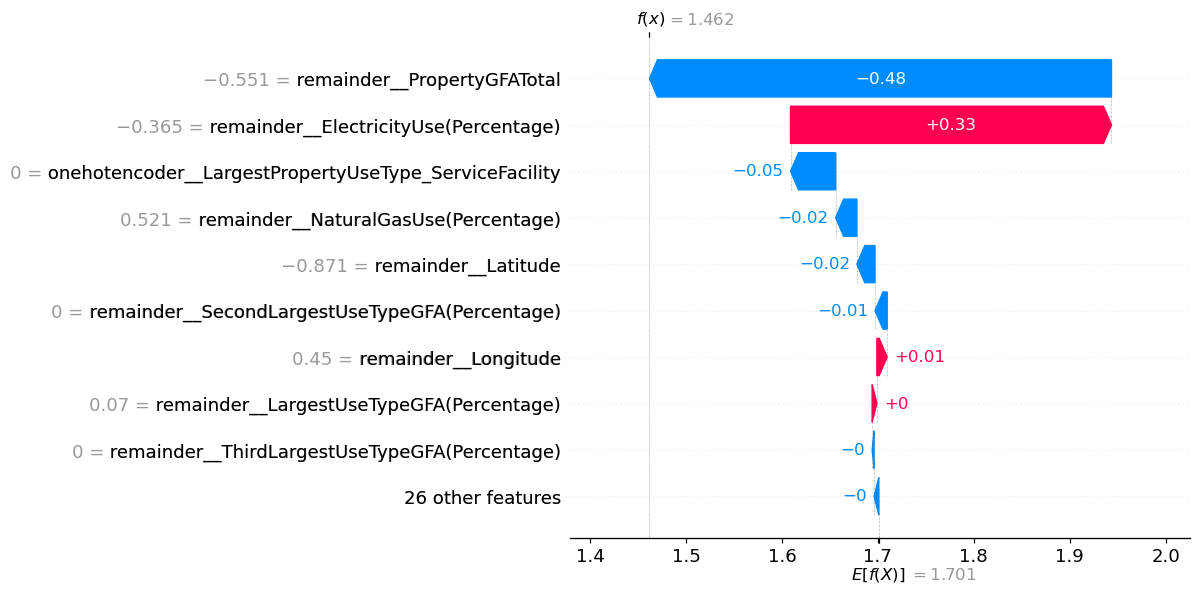

In [35]:
shap.plots.waterfall(shap_values[154])

# EnergyStarScore

In [36]:
y = energy_data["TotalGHGEmissions"]
X_with_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
    ],
    axis=1,
)
X_without_score = energy_data.drop(
    columns=[
        "SiteEnergyUse(kBtu)",
        "TotalGHGEmissions",
        "NumberOfYearsENERGYSTARCertified",
        "ENERGYSTARScore",
    ],
    axis=1,
)

(
    X_train_wo_score,
    X_test_wo_score,
    y_train_wo_score,
    y_test_wo_score,
) = split(X_without_score, y)

(
    X_train_with_score,
    X_test_with_score,
    y_train_with_score,
    y_test_with_score,
) = split(X_with_score, y)

ess_comparison = pd.DataFrame()

In [37]:
def predict(model, x_test, y_test, id, df):
    r2 = model.score(x_test, y_test)
    predictions = model.predict(x_test)
    y_true = np.power(10, y_test) - 1
    y_pred = np.power(10, predictions) - 1
    results = {
        "Test R2": round(r2, 2),
        "Test RMSE": round(np.sqrt(mean_squared_error(y_true, y_pred)), 4),
        "Test RMSE (Log)": round(np.sqrt(mean_squared_error(y_test, predictions)), 4),
    }

    ess_comparison = pd.concat(
        [df, pd.DataFrame(results, index=[id])], ignore_index=False
    ).sort_values(by="Test RMSE")
    display(ess_comparison)
    plot_predictions(y_test_wo_score, predictions)
    return ess_comparison

,Test R2,Test RMSE,Test RMSE (Log)
Without ESS,0.74,360.7051,0.2917


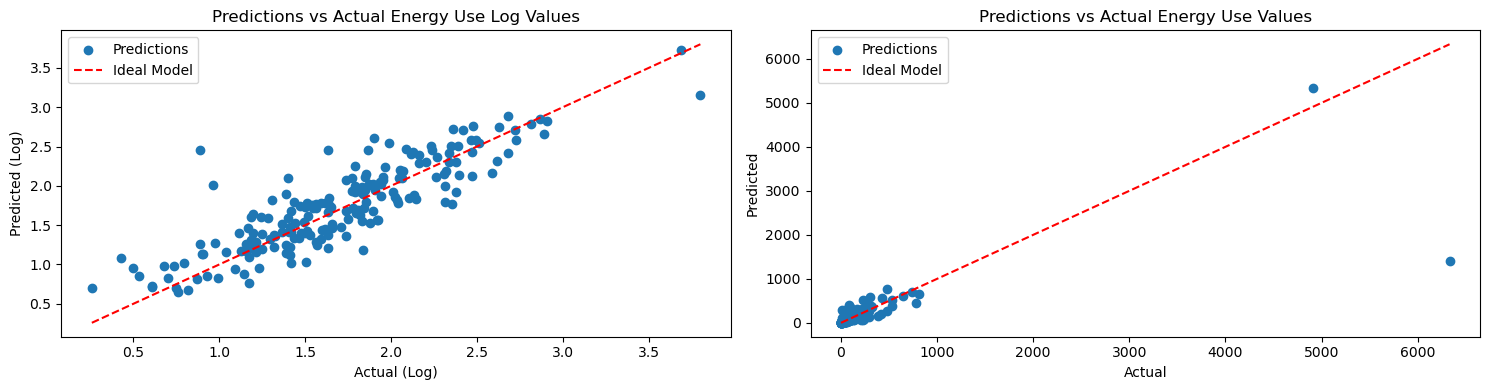

In [38]:
linear_regression = build_pipeline(LinearRegression())

linear_regression.fit(X_train_wo_score, y_train_wo_score)
ess_comparison = predict(
    linear_regression, X_test_wo_score, y_test_wo_score, "Without ESS", ess_comparison
)

We can now compare it with the score of the model with the EnergyStarScore information

,Test R2,Test RMSE,Test RMSE (Log)
With ESS,0.83,354.8089,0.2332
Without ESS,0.74,360.7051,0.2917


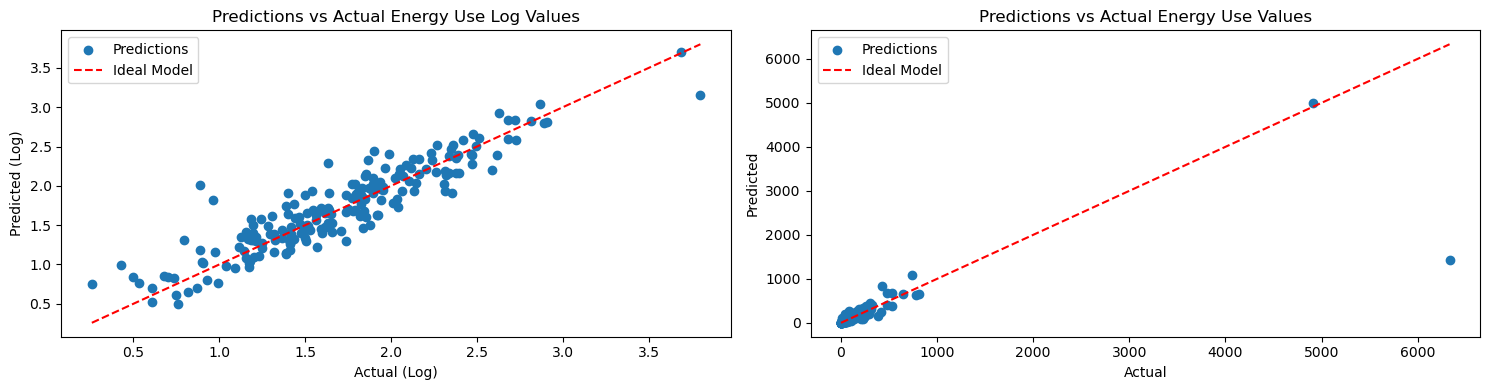

In [39]:
linear_regression.fit(X_train_with_score, y_train_with_score)
ess_comparison = predict(
    linear_regression, X_test_with_score, y_test_with_score, "With ESS", ess_comparison
)

Looking at the R2 score, it seems that the ESS improves the model significantly. However, the RMSE suggests that the model trained with ESS features still makes important errors. According to the graphs, these errors seem to be due to outliers, therefore further cleaning, along with additonal data, could further support the usefulness of the ESS.

With the given data set, the ESS does not seem worthwile to collect given the fact that the model is already pretty performant without it. 